In [1]:
%matplotlib widget

In [2]:
from pkgutil import get_data
from unittest import main
import adafruit_bno055
import busio# I2C用のインターフェースを使用するためのモジュール
import board
import sys
import json
import threading
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from collections import OrderedDict
import os
path = os.getcwd()
from IPython.display import display, clear_output
import plotly.graph_objects as go # to make a graph
from matplotlib.animation import FuncAnimation
import collections
from collections import deque
from time import perf_counter

In [3]:
        
def connect():
    try:
        i2c = busio.I2C(board.SCL, board.SDA)# I2CBusにアクセスするためのインターフェースを用意。SCLとSDAを使ってアクセス
        bno = adafruit_bno055.BNO055_I2C(i2c)# BNO055センサに接続する。DefaultではNDOF_MODE(12)
        #self.bno.use_external_crystal = True
        print("Established connection with BNO055")
        return i2c, bno
    except:
        print('Connection Error')
        sys.exit

In [4]:
def get_data(bno):
        
    '''
    センサからある時点の値を抽出
    '''
        
    euler_x, euler_y, euler_z = [val for val in bno.euler]# 角度[deg]
    gyro_x, gyro_y, gyro_z = [val for val in bno.gyro]# 角速度[rad/s]
    gravity_x, gravity_y, gravity_z = [val for val in bno.gravity]# 重力加速度[m/s^2]
    linear_accel_x, linear_accel_y, linear_accel_z = [val for val in bno.linear_acceleration]# 重力分を差し引いた加速度[m/s^2]
    accel_x, accel_y, accel_z = [val for val in bno.acceleration]# 重力+リニア加速度
    quaternion_1, quaternion_2, quaternion_3, quaternion_4 = [val for val in bno.quaternion]# クオータニオン
    calibstat_sys, calibstat_gyro, calibstat_accel, calibstat_mag = [val for val in bno.calibration_status]# キャリブレーション状態
        
    return euler_x, euler_y, euler_z, gyro_x, gyro_y, gyro_z, gravity_x, gravity_y, gravity_z,\
            linear_accel_x, linear_accel_y, linear_accel_z, accel_x, accel_y, accel_z,\
            quaternion_1, quaternion_2, quaternion_3, quaternion_4,\
            calibstat_sys, calibstat_gyro, calibstat_accel, calibstat_mag
    

In [19]:
def calc_eular_from_Q(bno):
    """
    Under development
    It is not work properly

    Args:
        bno (_type_): _description_

    Returns:
        _type_: _description_
    """
    euler_x, euler_y, euler_z = [val for val in bno.euler]# 角度[deg]
    quaternion_1, quaternion_2, quaternion_3, quaternion_4 = [val for val in bno.quaternion]# クオータニオン
    w = quaternion_1 / 16384
    x = quaternion_2 / 16384
    y = quaternion_3 / 16384
    z = quaternion_4 / 16384
    
    ysqr = y * y;

    # roll (x-axis rotation)
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + ysqr)
    roll = np.arctan2(t0, t1)
    

    # pitch (y-axis rotation)
    t2 = +2.0 * (w * y - z * x)
    
    t2 = 1.0 if t2 > 1.0 else t2
    t2 = -1.0 if t2 > -1.0 else t2
    pitch = np.arcsin(t2)
    
    # yaw (z-axis rotation)
    t3 = +2.0 * (w * z + x * y);
    t4 = +1.0 - 2.0 * (ysqr + z * z);  
    yaw = np.arctan2(t3, t4);
    
    roll *= 57.2957795131;
    pitch *= 57.2957795131;
    yaw *= 57.2957795131;
    
    return roll, pitch, yaw, euler_x, euler_y, euler_z

In [6]:

def monitor(bno):
    print('Monitor')
    IsMonitor = True
    try:
        print('Start Monitoring')       
        plt.ion()
        fig, ax = plt.subplots(3, 1, tight_layout=True)
        fig.set_figheight(8)
        fig.set_figwidth(12)
        """
        
        ax[0].set_xlabel("Time [s]")
        ax[0].set_ylabel("Longitudinal acceleration [m/s^2]")
        ax[1].set_xlabel("Time [s]")
        ax[1].set_ylabel("Lateral acceleration [m/s^2]")
        ax[2].set_xlabel("Time [s]")
        ax[2].set_ylabel("Yaw rate [rad/s]")
        """        
        
        
        counter = 0
        Logic_start_time = time.time()#計測用
        while True:
            start_time = time.time()# ループの一番最初
            Time = counter / BNO_UPDATE_FREQUENCY_HZ# 現在の時刻
            '''
            Time, euler_x, euler_y, euler_z, gyro_x, gyro_y, gyro_z, gravity_x, gravity_y, gravity_z,\
            linear_accel_x, linear_accel_y, linear_accel_z, accel_x, accel_y, accel_z,\
            quaternion_1, quaternion_2, quaternion_3, quaternion_4,\
            calibstat_sys, calibstat_gyro, calibstat_accel, calibstat_mag]
            '''                 
            #from IPython.core.debugger import Pdb; Pdb().set_trace()
            data = np.array([Time] + list(get_data(bno))).reshape(-1, len(COLUMNS))#センサからデータを抽出しTimeの結合
            
                        
            if counter == 0:
                assy_data = data.copy()

            else: 
                assy_data = np.concatenate((assy_data, data), axis = 0)# 行方向に結合

            if BNO_UPDATE_FREQUENCY_HZ <= 1.0:
            
                #Queue operation               
                Time_data.popleft()
                linear_accel_x_data.popleft()
                linear_accel_y_data.popleft()
                linear_accel_z_data.popleft()
                gyro_x_data.popleft()
                gyro_y_data.popleft()
                gyro_z_data.popleft()
                
                Time_data.append(data[-1,0])
                linear_accel_x_data.append(data[-1,10])
                linear_accel_y_data.append(data[-1,11])
                linear_accel_z_data.append(data[-1,12])
                gyro_x_data.append(data[-1,4])
                gyro_y_data.append(data[-1,5])
                gyro_z_data.append(data[-1,6])         
                
                
                # Graph
                # 極力グラフを書くだけにとどめる
                clear_output(wait = True)
                plt.cla()
                ax[0].plot(Time_data,linear_accel_x_data,linestyle='-', color='r', linewidth=1)
                ax[1].plot(Time_data,linear_accel_y_data,linestyle='-', color='r', linewidth=1)
                ax[2].plot(Time_data,np.rad2deg(gyro_z_data),linestyle='-', color='r', linewidth=1)# グラフ化の時はrad2degにしておく
                display(fig)
            
            
            executed_time = time.time()# ある関数が終わった直後
            wait_process((1.0 / BNO_UPDATE_FREQUENCY_HZ) - (executed_time - start_time))
            counter += 1            
            
            
    except KeyboardInterrupt as e:
        end_time = time.time()
        # 経過時間を出力(秒)
        elapsed_time = end_time - Logic_start_time
        print(elapsed_time)
        print('executed ctrl-c')
        assy_data = pd.DataFrame(assy_data, columns=list(COLUMNS))
        assy_data.to_csv(datapath + '/'+ str(time.time()) +'_data.csv')
        return assy_data
    except:
        print('Error')
        assy_data = pd.DataFrame(assy_data, columns=list(COLUMNS))
        assy_data.to_csv(datapath + '/'+ str(time.time()) +'_data.csv')
    
    return
            


In [7]:
def start(self):
    print('Start Logging')
    return

In [8]:
from time import perf_counter
def wait_process(wait_sec):
    until = perf_counter() + wait_sec
    while perf_counter() < until:
        pass
    return

Start Application
Established connection with BNO055
Monitor
Start Monitoring
28.763720512390137
executed ctrl-c


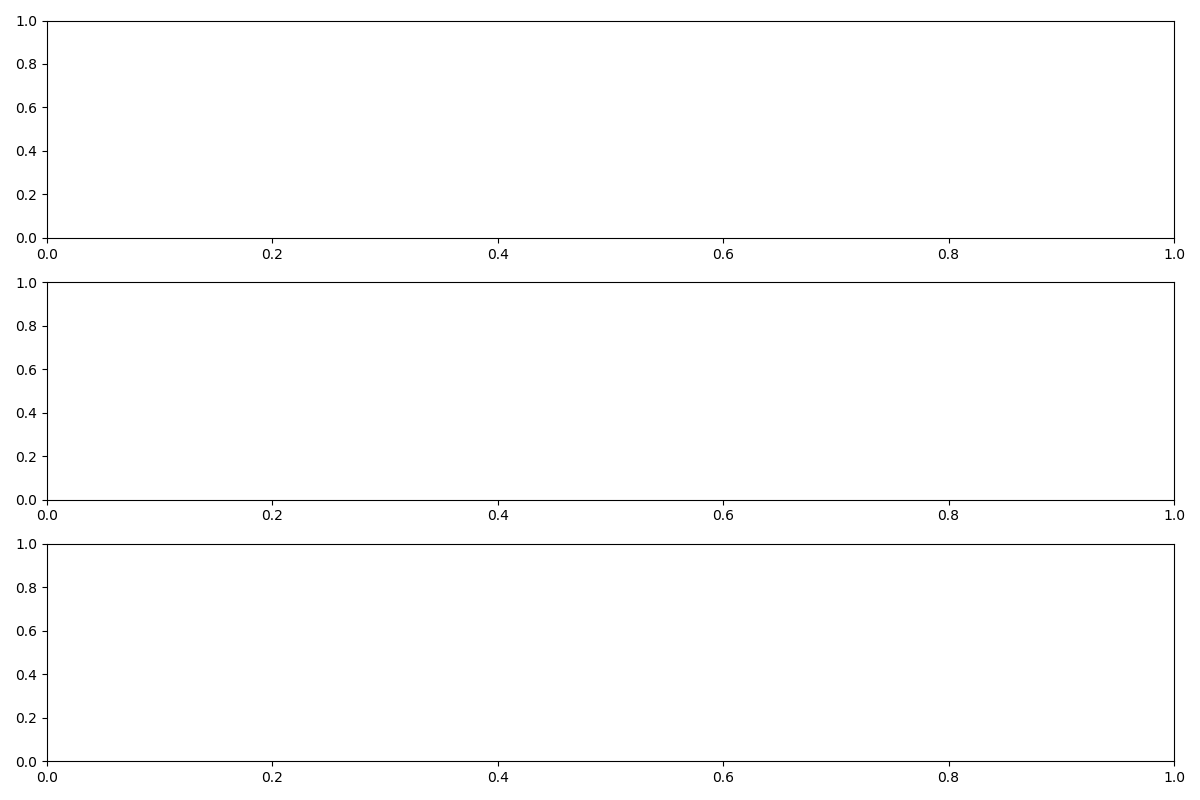

In [9]:
if __name__ == '__main__':
    

    IsStartStop = False# False:Stop, True:Start
    IsMonitor = False# False:Not monitoring, True:Monitoring
    BNO_UPDATE_FREQUENCY_HZ = 10#100Hz、50、20は無理
    
    COLUMNS = ["Time","euler_x", "euler_y", "euler_z", "gyro_x", "gyro_y", "gyro_z", "gravity_x", "gravity_y", "gravity_z",
                "linear_accel_x", "linear_accel_y", "linear_accel_z","accel_x", "accel_y", "accel_z",
                "quaternion_1", "quaternion_2", "quaternion_3", "quaternion_4", 
                "calibstat_sys", "calibstat_gyro", "calibstat_accel", "calibstat_mag"]
    exepath = path + '/measurement_system'
    datapath = path + '/data'
    
    INTERVAL = 1000
    INIT_LEN = INTERVAL // BNO_UPDATE_FREQUENCY_HZ

    Time_data = collections.deque(np.zeros(INIT_LEN))# Time
    linear_accel_x_data = collections.deque(np.zeros(INIT_LEN))# linear_accel_x
    linear_accel_y_data = collections.deque(np.zeros(INIT_LEN))# linear_accel_y
    linear_accel_z_data = collections.deque(np.zeros(INIT_LEN))# linear_accel_z
    gyro_x_data = collections.deque(np.zeros(INIT_LEN))# gyro_x
    gyro_y_data = collections.deque(np.zeros(INIT_LEN))# gyro_y
    gyro_z_data = collections.deque(np.zeros(INIT_LEN))# gyro_z
    
    
        
    print('Start Application')
    
    i2c, bno = connect()
    calc_eular_from_Q(bno)
    
    mode = '1'
    if mode == '1':# Monitor mode
        
        assy_data = monitor(bno)
    elif mode == '2':# Start Logging
        start()
    else:
        print()

In [9]:
i2c, bno = connect()

Established connection with BNO055


In [21]:
calc_eular_from_Q(bno)

(-2.525649847560555e-09,
 -90.00000000002777,
 -4.903151048823004e-08,
 13.25,
 -0.8125,
 0.625)

/usr/lib/python3/dist-packages/matplotlib/pyplot.py:528: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



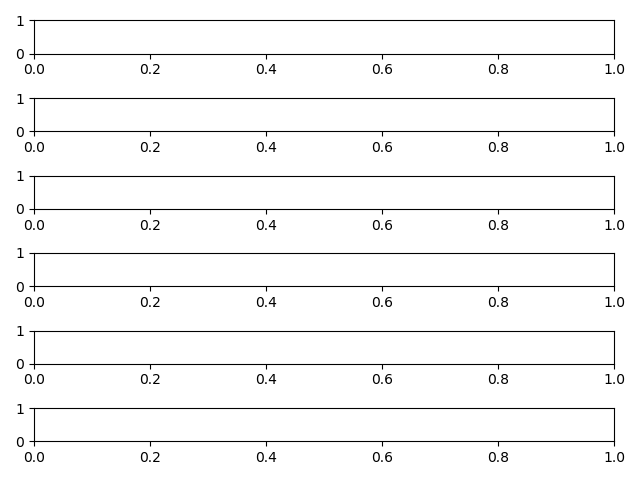

In [72]:
fig1, ax1 = plt.subplots(6, 1, tight_layout=True)

In [73]:
ax1[0].plot(assy_data['Time'], assy_data['linear_accel_x'], 'k')
ax1[1].plot(assy_data['Time'], assy_data['linear_accel_y'], 'k')
ax1[2].plot(assy_data['Time'], assy_data['linear_accel_z'], 'k')
ax1[3].plot(assy_data['Time'], assy_data['gyro_x'], 'k')
ax1[4].plot(assy_data['Time'], assy_data['gyro_y'], 'k')
ax1[5].plot(assy_data['Time'], assy_data['gyro_z'], 'k')

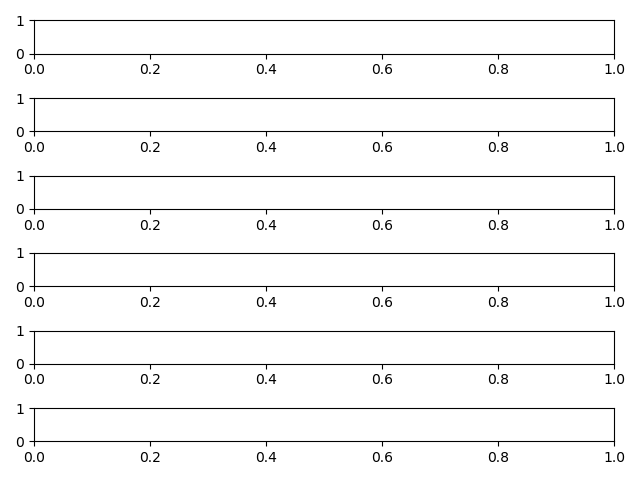

In [74]:
fig2, ax2 = plt.subplots(6, 1, tight_layout=True)

In [75]:
ax2[0].plot(assy_data['Time'], assy_data['linear_accel_x'], 'k')
ax2[1].plot(assy_data['Time'], assy_data['linear_accel_y'], 'k')
ax2[2].plot(assy_data['Time'], assy_data['linear_accel_z'], 'k')
ax2[3].plot(assy_data['Time'], assy_data['euler_x'], 'k')
ax2[4].plot(assy_data['Time'], assy_data['euler_y'], 'k')
ax2[5].plot(assy_data['Time'], assy_data['euler_z'], 'k')

In [20]:
plt.ylim(-0.2,0.2)

(-0.2, 0.2)

In [58]:
plt.xlim(60, 80)

(60, 80)

In [64]:
bno.euler

(12.375, -2.0625, 4.25)

In [65]:
bno.euler

(85.1875, -1.875, 4.25)

In [66]:
bno.euler

(15.1875, -0.25, -86.3125)

In [67]:
bno.euler

(20.5625, -88.6875, 0.1875)